## Logistic Regression

<img src="./images/anime.png" width="500"/>

Вычислительный граф для модели логистической регрессии:

![caption](./images/graph.png)

Алгоритм SGD:

0. Инициализируем веса.
1. Сэмплируем batch_size примеров из выборки.
2. Forward pass: вычисляем значения в узлах вычислительного графа.
3. Backward pass: считаем градиенты $\frac{dL}{dw}$ Loss-функции по отношению к параметрам модели.
4. Обновляем параметры:
$$ w := w - lr*\frac{dL}{dw} $$
5. Если не выполнен критерий завершения (превышено число итераций, параметры перестали существенно изменяться и т.п.), вернуться на шаг 1.

Реализуйте вычисление сигмоиды и постройте её график в одномерном случае.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
def sigmoid(x):
    # return 1 / (1 + np.exp(-x))  # np.nan with x tending to -np.inf
    ans = np.zeros_like(x)
    ans[x >= 0] = 1 / (1 + np.exp(-x[x >= 0]))
    ans[x < 0] = np.exp(x[x < 0]) / (1 + np.exp(x[x < 0]))
    return ans

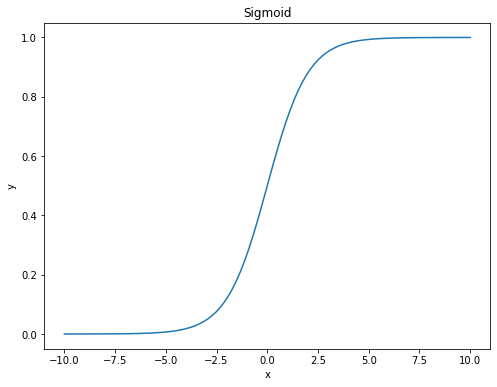

In [3]:
plt.figure(figsize=(8, 6))

x = np.linspace(-10., 10., 100)
plt.plot(x, sigmoid(x))

plt.title("Sigmoid")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Реализуйте методы fit, predict, BCE, _init_weights в классе LogisticRegression.

In [4]:
class LogisticRegression:
    def __init__(self):
        self.w = None
        self.b = None

    @staticmethod
    def sigmoid(x):
        return sigmoid(x)

    @staticmethod
    def transform_one_hot(y):
        n_classes = max(y) + 1  # classes start from 0
        one_hot = np.zeros(shape=(y.shape[0], n_classes))
        one_hot[tuple((np.arange(y.shape[0]), y))] = 1
        y = one_hot
        return y

    @staticmethod
    def loss(*args, **kwargs):
        return LogisticRegression.BCE(*args, **kwargs)

    @staticmethod
    def BCE(y, x):
        pred = np.maximum(x, 1e-5)
        pred = np.minimum(pred, 1 - 1e-5)
        ans = (-1. * y * np.log(pred) - 1. * (1. - y) * np.log(1. - pred)).mean(axis=-1)
        return ans

    @staticmethod
    def sample_batch(X_train, y_train, batch_size):
        if not batch_size is None:
            rand_idx = np.random.permutation(X_train.shape[0])[:batch_size]
            X, y = X_train[rand_idx, ...], y_train[rand_idx, ...]
        else:
            X, y = X_train, y_train
        return X, y

    def fit(self, 
            X_train, y_train, 
            iters=10000, 
            lr_base=0.01, 
            steps=4, 
            batch_size=None, 
            print_freq=2000):
        """
        fit model to data

        params:
            X_train, y_train - training data. Shapes are:
                X_train: (N_samples, N_features),
                y_train: (N_samples, N_classes),
            iters - number of iterations to train
            lr_base - base learning rate
            steps - number of steps to drop the LR
            batch_size - batch size (== X.shape[0] if None)
            weight decay - lambda coefficient for L2 regularization
            print_freq - frequency of logging
        """

        self.N = X_train.shape[0]
        self.D = X_train.shape[1]
        self.O = y_train.shape[1]
        if  self.w is None or \
            self.b is None or \
            self.w.shape != (self.D, self.O) or \
            self.b.shape != (1., self.O):

            self._init_weights()

        for i in range(iters):
            # sample data
            X, y = self.sample_batch(X_train, y_train, batch_size)

            # forward pass
            z = X.dot(self.w) + self.b
            o = self.sigmoid(z)
            loss = self.loss(y, o).mean()

            # backward pass
            dz = o - y
            dw = X.T.dot(dz) / X.shape[0]
            db = dz.mean(axis=0)

            # update params
            lr = lr_base * 0.1 ** (i // (iters // steps))
            self.w -= lr * dw
            self.b -= lr * db

            # log
            if (i + 1) % print_freq == 0:
                print("iter: {}, loss: {:5.3f}, lr: {:5.6f}".format(i + 1, loss, lr))

        return self

    def predict(self, X):
        return self.sigmoid(X.dot(self.w) + self.b)

    def _init_weights(self):
        self.w = np.random.uniform(0, 0.01, size=(self.D, self.O))
        self.b = np.ones(shape=(1, self.O)) / 100

Протестируем обучение модели на простом примере.

In [5]:
X = np.array([[0, 0],
              [0, 1],
              [1, 0],
              [1, 1]])
y = np.array([[0], [1], [1], [1]])

In [6]:
model = LogisticRegression().fit(X, y)

iter: 2000, loss: 0.267, lr: 0.010000
iter: 4000, loss: 0.233, lr: 0.001000
iter: 6000, loss: 0.228, lr: 0.000100
iter: 8000, loss: 0.227, lr: 0.000010
iter: 10000, loss: 0.227, lr: 0.000010


In [7]:
model.predict(X)

array([[0.43292542],
       [0.85270028],
       [0.85288537],
       [0.97775794]])

Протестируем обучение модели на другом примере.

In [8]:
X = np.array([[0, 0],
              [0, 1],
              [1, 0],
              [1, 1]])
y = np.array([[0], [1], [1], [0]])

In [9]:
model = LogisticRegression().fit(X, y)

iter: 2000, loss: 0.693, lr: 0.010000
iter: 4000, loss: 0.693, lr: 0.001000
iter: 6000, loss: 0.693, lr: 0.000100
iter: 8000, loss: 0.693, lr: 0.000010
iter: 10000, loss: 0.693, lr: 0.000010


In [10]:
model.predict(X)

array([[0.50003621],
       [0.49984697],
       [0.5001645 ],
       [0.49997526]])

Каким получается качество? Почему так происходит?

## Боевое применение 

Протестируйте написанную вами модель логистической регрессии на датасете для классификации ирисов. Подробнее об этом датасете можно почитать [тут](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0).

In [11]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

Разделим данные на обучающую и валидационную выборку. Сконвертируем y в формат one_hot_encoding и обучим модель.

In [12]:
X, y = load_iris(return_X_y=True)
# make y one-hot encoded:
y = LogisticRegression.transform_one_hot(y)
print(X.shape, y.shape, y.min(), y.max())
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=1, test_size=0.25)

(150, 4) (150, 3) 0.0 1.0


In [13]:
model = LogisticRegression().fit(X_train, y_train, lr_base=0.1, batch_size=32)

iter: 2000, loss: 0.225, lr: 0.100000
iter: 4000, loss: 0.220, lr: 0.010000
iter: 6000, loss: 0.170, lr: 0.001000
iter: 8000, loss: 0.173, lr: 0.000100
iter: 10000, loss: 0.185, lr: 0.000100


Подсчитаем точность. Постарайтесь сделать так, чтобы точность была не ниже 85%. Возможно, понадобится покрутить параметры модели (или починить баги).

In [14]:
pred_val = model.predict(X_val).argmax(axis=1)
gt_val = y_val.argmax(axis=1)
acc = 1 - (pred_val != gt_val).sum() / y_val.shape[0]
print("model accuracy:", acc)

model accuracy: 0.9473684210526316


## Визуализация 

Визуализируйте разделяющую плоскость. Тестируйте на двумерных синтетических данных для простоты дебага и визуализации.

In [15]:
np.random.seed(0)

# create some dummy data
C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.concatenate([np.ones(200, dtype=np.int32), np.zeros(200, dtype=np.int32)])[:, None]

# plot_decision_boundary
model = LogisticRegression().fit(X, y, lr_base=0.01)


iter: 2000, loss: 0.402, lr: 0.010000
iter: 4000, loss: 0.379, lr: 0.001000
iter: 6000, loss: 0.375, lr: 0.000100
iter: 8000, loss: 0.375, lr: 0.000010
iter: 10000, loss: 0.375, lr: 0.000010


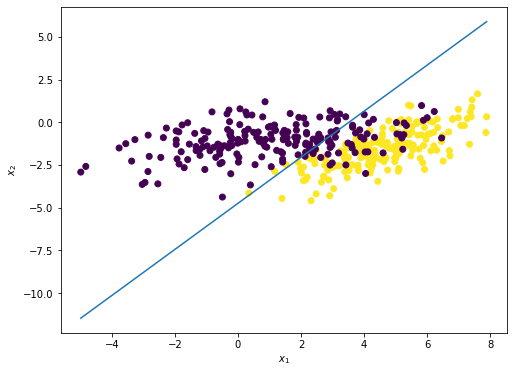

In [16]:
xticks = np.linspace(X[:, 0].min(), X[:, 0].max(), 10)
yticks = -model.w[0, 0] / model.w[1, 0] * xticks - model.b[0, 0] / model.w[1, 0]

plt.figure(figsize=(8, 6))

plt.scatter(X[:, 0], X[:, 1], c=y[:, 0])
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.plot(xticks, yticks)

Визуализируем также с помощью трёхмерного графика, как изменяются предсказания модели в зависимости от точки пространства.

Text(0.5, 0, 'prob')

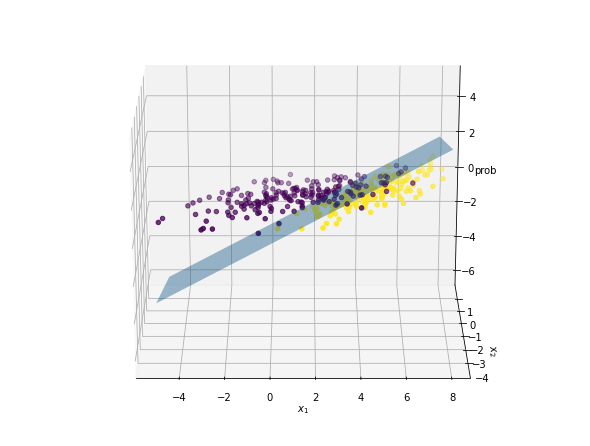

In [17]:
xticks = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
yticks = np.linspace(X[:, 1].min(), X[:, 1].max(), 100)

pred = model.sigmoid(model.w[0, 0] * X[:, 0] + model.w[1, 0] * X[:, 1] + model.b[0, 0])

xxx, yyy = np.meshgrid(xticks, yticks)
zzz = model.w[0, 0] * xxx + model.w[1, 0] * yyy + model.b[0, 0]
# zticks = model.sigmoid(model.w[0, 0] * xxx + model.w[1, 0] * yyy + model.b[0, 0])

fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig, azim=-90, elev=20)

ax.scatter(X[:, 0], X[:, 1], pred, c=y[:, 0])
ax.plot_surface(xxx, yyy, zzz, alpha=0.5)
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("prob")